## Gaussian Puff Model

Yunha Lee 
August 7, 2024


# Pre-Step: Get weather data for the target area and times

In [ ]:

##TODO GET_STABILITY_CLASS MUST TAKE SURFACE_WIND, not the U_Wind!! 

import pandas as pd
import xarray as xr

# Define the path and variables
weather_file_names = ['u_wind', 'v_wind', 'wind_direction', 'vertical_velocity', 'temperature']
data_dir = "/Users/yunhalee/Documents/methanDart/UCAR_reanalysis/"
geopotential_file = f"{data_dir}geopotential_height_NorthAmerica.nc"

# Define source locations and time range
source_locs = pd.DataFrame({
    'lat': [34.05, 34.06],
    'lon': [-118.25, -118.26],
    'height': [10, 50]  # Heights in meters
})
start_time = pd.to_datetime("2015-06-01 12:00:00")
end_time = pd.to_datetime("2015-06-10 12:00:00")

# Read geopotential height to find the corresponding pressure levels
with xr.open_dataset(geopotential_file) as ds:
    ds_gph = ds.sel(time=slice(start_time, end_time))

    # Dictionary to hold DataFrames for each location
    location_weather_data = {}

    # Iterate over each location
    for index, row in source_locs.iterrows():
        loc_id = f"lat{row['lat']}_lon{row['lon']}_height{row['height']}"
        loc_weather_data = pd.DataFrame()

        # Iterate over each weather variable
        for var_name in weather_file_names:
            with xr.open_dataset(f"{data_dir}{var_name}_NorthAmerica.nc") as ds_var:
                ds_var = ds_var.sel(time=slice(start_time, end_time))

                # Get the nearest geopotential heights for this location and convert heights to pressure levels
                gph_values = ds_gph.sel(latitude=row['lat'], longitude=row['lon'], method='nearest')

                # Print dimensions to debug
                print("Dimensions of gph_values:", gph_values.dims)

                if 'time' in gph_values.dims:
                    gph_values = gph_values.isel(time=0)  # selecting the first time point for simplicity

                # Continue with height comparison
                height_diff = abs(gph_values['geopotential_height'] - row['height'])
                nearest_pressure_level_idx = height_diff.argmin(dim='isobaricInhPa')
                nearest_pressure_level = gph_values['isobaricInhPa'].isel(isobaricInhPa=nearest_pressure_level_idx).values

                print("Type of nearest_pressure_level:", type(nearest_pressure_level))
                print("Value of nearest_pressure_level:", nearest_pressure_level)


                var_data = ds_var.sel(latitude=row['lat'], longitude=row['lon'], isobaricInhPa=nearest_pressure_level, method='nearest')
                df_var = var_data.to_dataframe()

                # Renaming columns to reflect data specifics
                new_column_names = {
                    name: f"{name}"
                    for name in df_var.columns
                }

                df_var.rename(columns=new_column_names, inplace=True)
                if loc_weather_data.empty:
                    loc_weather_data = df_var
                else:
                    loc_weather_data = pd.merge(loc_weather_data, df_var, how='outer', left_index=True, right_index=True, suffixes=('', '_duplicate'))
                    duplicate_columns = [col for col in loc_weather_data.columns if '_duplicate' in col]
                    loc_weather_data.drop(columns=duplicate_columns, inplace=True)

        location_weather_data[loc_id] = loc_weather_data

        loc_weather_data.to_csv(f"../input_data/{loc_id}_weather_data.csv")

for loc_id, df in location_weather_data.items():
    print(f"Data for {loc_id}:")
    print(df.head())


## Run the GPM model

The end time of the simulation will be: 2015-06-01 13:00:00
Data for lat34.05_lon-118.25_height10.0:
The end time of the Plume simulation will be: 2015-06-01 12:00:01
filtered_data:                      isobaricInhPa   latitude   longitude  u_wind  v_wind  \
time                                                                        
2015-06-01 12:00:00         1000.0  34.035014 -118.124916     0.3     1.3   

                     wind_direction  vertical_velocity  temperature  
time                                                                 
2015-06-01 12:00:00       192.99463           0.000169        288.4  
filtered_data: 1
Interpolated weather data:                      isobaricInhPa   latitude   longitude  u_wind  v_wind  \
time                                                                        
2015-06-01 12:00:00         1000.0  34.035014 -118.124916     0.3     1.3   

                     wind_direction  vertical_velocity  temperature  
time                          

/Users/yunhalee/Documents/methanDart/Gaussian_Puff_CH4/code/gaussian_puff_functions.py:167: RuntimeWarning: invalid value encountered in log
  big_theta = 0.017453293 * (c - d * np.log(total_dist[mask]))
/Users/yunhalee/Documents/methanDart/Gaussian_Puff_CH4/code/gaussian_puff_functions.py:169: RuntimeWarning: invalid value encountered in power
  class_sigma_z[mask] = np.minimum(a * (total_dist[mask] ** b), 5000)


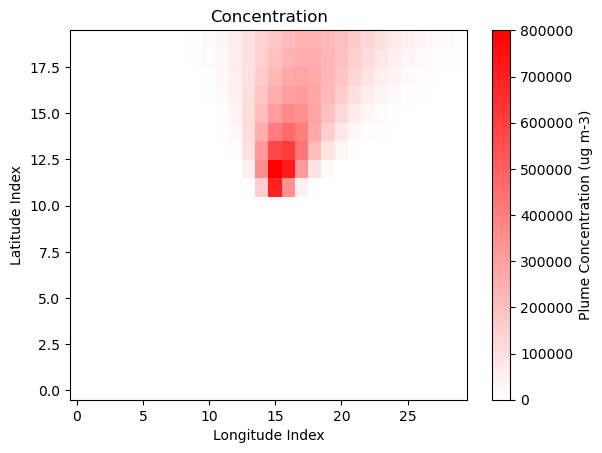

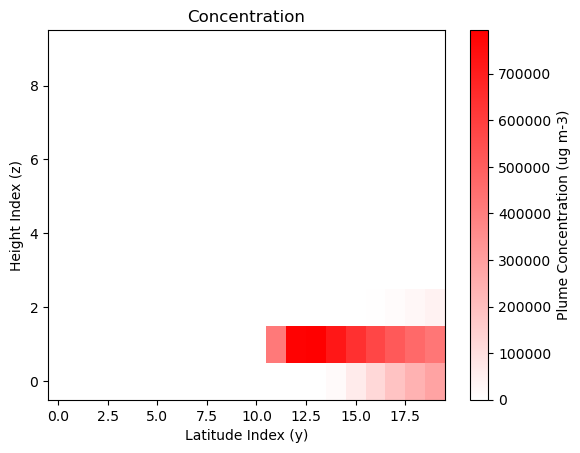

In [2]:
import numpy as np
from datetime import timedelta
import pandas as pd
from gaussian_puff_functions import *
from pyproj import Proj, Transformer

# Define source locations and time range
source_locs = pd.DataFrame({
    'lat': [34.05],
    'lon': [-118.25],
    'height': [10]  # Heights in meters
})

# Define the size of the simulation domain
area_size = 100  # domain size in meters 
height_levels = 100 # domain heigh in meters
dt = 1  # sec
emission_rate = 1  # kg/s

# Set which model to use
GAUSSIAN_PUFF = False # False
GAUSSIAN_PLUME = True #True

# Determine the simulation duration using chunk_size and n_chunk (for multiprocessing)
chunk_size = 10  # Number of minutes in each chunk
n_chunks = 6 # Number of chunks (also, number of processors)
start_time = pd.to_datetime("2015-06-01 12:00:00")

end_time = calculate_end_time(start_time, chunk_size, n_chunks)
print(f"The end time of the simulation will be: {end_time}")

# Create a sequence of seconds between start_time and end_time
times = pd.date_range(start=start_time, end=end_time, freq=f'{dt}s')

# Remove the last timestamp to make round number for multi-processing (3600 instead of 3601)
times = times[:-1]


output_dir = "/Users/yunhalee/Documents/methanDart/Gaussian_Puff_CH4/output_data/"

# Prepare to store the results
all_data = []

# Iterate over each location
for s, row in source_locs.iterrows():
    loc_id = f"lat{row['lat']}_lon{row['lon']}_height{row['height']}"
    print(f"Data for {loc_id}:")

    data = pd.read_csv (f"../input_data/{loc_id}_weather_data.csv")
    data['time'] = pd.to_datetime(data['time'])
    data.set_index('time', inplace=True)

    # Resample the data to 1-minute intervals from 3-hourly data
    minute_data = data.resample('1min').mean()
    minute_data = minute_data.interpolate(method='linear')

    if (GAUSSIAN_PUFF):
        # Filter the data between start_time and end_time
        filtered_data = minute_data[start_time:end_time]

        print("filtered_data:", filtered_data.head())
        print("filtered_data:", len(filtered_data))

        resampled_data = filtered_data.resample(f'{dt}s').mean()
        resampled_data = resampled_data.interpolate(method='linear')

        # Remove the last timestamp to make round number for multi-processing (3600 instead of 3601)
        resampled_data = resampled_data[:-1]

    elif (GAUSSIAN_PLUME):

        # Filter the data between start_time and end_time
        end_time = start_time +timedelta(seconds=dt)
        print(f"The end time of the Plume simulation will be: {end_time}")

        filtered_data = minute_data[start_time:end_time]

        print("filtered_data:", filtered_data.head())
        print("filtered_data:", len(filtered_data))

        resampled_data = filtered_data.resample(f'{dt}s').mean()
        resampled_data = resampled_data.interpolate(method='linear')


    print("Interpolated weather data:", resampled_data.head())
    print("Interpolated weather data:", len(resampled_data))

    print(f"Source: {s + 1}/{len(source_locs)}")

    # Source location and conversion to UTM
    source_lat = source_locs.iloc[s]['lat']
    source_lon = source_locs.iloc[s]['lon']
    source_x, source_y = latlon_to_utm(source_lat, source_lon)
    source_z = source_locs.iloc[s]['height']

    # Define a 3D grid or area over which to calculate concentration
    grid_x, grid_y, grid_z = np.meshgrid(np.linspace(source_x-area_size/2, source_x+area_size/2, num=30),
                                         np.linspace(source_y-area_size/2, source_y+area_size/2, num=20),
                                         np.linspace(0, source_z + height_levels, num=10), indexing='ij')  
    
    print("grid dimension", grid_x.shape, grid_y.shape, grid_z.shape)
    
    if (GAUSSIAN_PUFF):
        big_C = simulate_puff_concentration(source_x, source_y, source_z, grid_x, grid_y, grid_z, resampled_data, dt, emission_rate, times, chunk_size, n_chunks)

        plot_2d_concentration(big_C, times) 

        # 3D plotting is done but it is hard to see the plume

        # Average the output from big_C, which has 1 sec time step. 
        output_dt_sec = 60*10  
        df_resampled_big_C = average_time_resolution(big_C, times, output_dt_sec, output_dir, grid_x, grid_y, grid_z)

        plot_2d_concentration_from_df(df_resampled_big_C)
    elif (GAUSSIAN_PLUME):

        # Rough time estimate for the plume to reach steady state given the condition
        rough_steady_state_time = area_size/2/np.sqrt(resampled_data['u_wind'].mean()**2 + resampled_data['v_wind'].mean() **2) 
        print(f"This plume will reach to the steady state approximately {rough_steady_state_time} second")

        conc = simulate_plume_concentration(source_x, source_y, source_z, grid_x, grid_y, grid_z, resampled_data,  emission_rate, times)
        plot_2d_plume_concentration(conc) 


    """ 
    # Transform UTM to Coordinate 
    df = df_resampled_big_C.copy()

    utm_zone = int((source_locs.iloc[0]['lon']  + 180) / 6) + 1
    hemisphere = 'north'

    print(utm_zone, source_locs.iloc[0]['lon'])

    # Create the transformer without the extra comma
    transformer = Transformer.from_proj(
        proj_from=f"+proj=utm +zone={utm_zone} +{hemisphere} +ellps=WGS84 +datum=WGS84 +units=m +no_defs",
        proj_to="epsg:4326",  # WGS84, which is the standard for latitude and longitude
        always_xy=True
    )

    # Apply transformation
    lon, lat = transformer.transform(df['lon'].values, df['lat'].values)
    df['lon'] = lon
    df['lat'] = lat

    print(df.head())

    plot_2d_concentration_from_df(df)
    """


In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LinearSegmentedColormap 

colors = ["white", "red"]  # white for low concentrations, red for high
cmap = LinearSegmentedColormap.from_list("custom_red", colors, N=256)

# Sum over the X (longitude dimension)
C_summed = np.mean(conc*40, axis=0)

print(C_summed.shape, np.percentile(C_summed, 93))

# Create the plot
fig, ax = plt.subplots()

# Plotting with y on the x-axis and z on the y-axis
c = ax.imshow(C_summed.T, cmap=cmap, origin='lower', aspect='auto', vmin=0, vmax=np.percentile(C_summed, 93))

ax.set_title('Concentration')
ax.set_xlabel('Latitude Index (y)')
ax.set_ylabel('Height Index (z)')

# Add a color bar
cbar = fig.colorbar(c, ax=ax)
cbar.set_label('Plume Concentration (ug m-3)')

# Display the plot
plt.show()

## For Puff simulation, here is the plot for the last time step (at 3599 sec)

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LinearSegmentedColormap 

colors = ["white", "red"]  # white for low concentrations, red for high
cmap = LinearSegmentedColormap.from_list("custom_red", colors, N=256)
time_steps = big_C.shape[0]

for t in range(time_steps):
    if t % 3599 == 0 and t != 0 :
        print(f"Plotting time step {t}")
        fig, ax = plt.subplots()

        # Sum over the Z-axis
        C_t_summed = np.sum(big_C[t], axis=2) 

        # Create the heatmap
        c = ax.imshow(C_t_summed, cmap=cmap, origin='lower', aspect='auto', vmin=0)
        ax.set_title(f'Concentration at time {times[t]}')
        ax.set_xlabel('Longitude Index')
        ax.set_ylabel('Latitude Index')

        # Add a color bar
        cbar = fig.colorbar(c, ax=ax)
        cbar.set_label('BigC Concentration (units)')

        # Display the plot
        plt.show()



In [ ]:
import numpy as np

def wind_components(ws, wd):
    """
    Calculate the u (eastward) and v (northward) components of wind speed.

    Parameters:
    ws (float or np.array): Wind speed in m/s.
    wd (float or np.array): Wind direction in degrees (from which the wind is blowing).

    Returns:
    u (float or np.array): Eastward wind component.
    v (float or np.array): Northward wind component.
    """
    # Convert wind direction to radians
    wd_rad = np.radians(wd)

    # Calculate the u and v components
    u = -ws * np.sin(wd_rad)
    v = -ws * np.cos(wd_rad)

    return u, v

# Example usage
ws = 10  # Wind speed in m/s
wd = 45  # Wind direction in degrees (northeast wind)

u, v = wind_components(ws, wd)
print(f"u (eastward component): {u} m/s")
print(f"v (northward component): {v} m/s")